In [1]:
import sys
sys.path.append("../src/") 
import os



import model_manipulation as mm
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
from cobra import Reaction
import model_initialize as model_init
# from model_initialize import *

Checklist:
- add wild type script to this script //
- Change names to reflect WT and trans //
- Incorporate graphs for both WT and trans//

- Check WT FVA @ 1000 PPFD to check CO2 intake and base CO2 script from there.



In [2]:
#Read 2-cell model
model = cobra.io.read_sbml_model("../model/ios2164_2cell.xml")
model.solver = 'gurobi'

inf = 1e6

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-03


In [3]:
#This codeblock is to define some of the functions used for modelling

#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light
def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='../misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='../misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    #For input fluxes for light, we will set the flux ratio to 10:1 to reflect the anatomical proportions of our model ()
    
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    
    #UPDATE: Change CO2 intake to the M Cell instead rather than set a ratio, which is a better assumption overall. Assume na lang that external gasses are assimilated
    #Via the M cell.
    #From Morrison et al 2005 -- Lateral diffusion of Gases is unlikely to support photosynthesis due to the
    #assimilation of diffused CO2 in tissues prior to BS//
    model.reactions.CO2tex_BS.bounds = (0,0)
    model.reactions.O2tex_BS.bounds = (0,0)
    
    #UPDATE: This assumption does not hold considering that recent transcriptomic analysis confirms that 
    #the bundle sheath is involved in the assimilation of inorganic nutrients, including nitrogen (nitrates/ammonia), and 
    #Sulfates. In turn, this will be implemented by simply setting the exchanges to the M cell to 0. (Hua et al, 2021)
    model.reactions.SO3tex_M.bounds = (0,0)
    model.reactions.SO4tex_M.bounds = (0,0)
    model.reactions.NH4tex_M.bounds = (0,0)
    model.reactions.NO3tex_M.bounds = (0,0)
    
    #Model will also constraint H2O input to BS cell only as it is also assumed that BS tissue in rice is specialized for H2O transport (Hua et al. 2021)
    #The model also will allow one-way flux of H2O out of the M cell in the form of evaporation (shown by -inf lower bound for the reaction)
    model.reactions.H2Otex_M.bounds = (-inf, 0)
    
    #No constraints will be implemented for H+ availability allowing the model to use protons on-demand.

    # #This code block contains constraints specific for enzyme rate constraints
    #This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
    #fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
    #At 0. For reversible reactions the lower bounds are set to the same value
    
def add_enzyme_constraints(model, 
                           wt_pepc = 0, 
                           wt_mdh = 11.18, 
                           wt_nadp_me = 0.14, 
                           wt_ppdk=0.31,
                          wt_CA=7.5):
    
    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M

    wt_pepc_cons = model.problem.Constraint(pepc_BS.flux_expression 
                                            + pepc_M.flux_expression, 
                                            lb = 0, ub = wt_pepc)
    wt_pepc_cons.name = 'wt_pepc_cons'
    model.add_cons_vars(wt_pepc_cons)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    mdhm_M = model.reactions.MDHm_M


    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= 0, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    nadp_me_M = model.reactions.MDHys_M
    nadp_me_BS = model.reactions.MDHys_BS

    wt_nadpme_cons = model.problem.Constraint(nadp_me_M.flux_expression
                                             + nadp_me_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional


    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)
    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)

    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena et al (2022) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,inf)
    ngam_atp_bs.bounds = (0,inf)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    #Compute NGAM value and add constraint as a lower bound/upper bound to model
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_ATP_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)

In [ ]:
model.reactions.H2Ot

#Add transgenic reactions to model localized to specific compartment

Transgenic (Line 29 - Ermakova et al)
PEPC = Chloroplastic in M & V (rxn id: PPCc)
PPDK = Chloroplastic in M and BS (rxn id: PPDKs)
NADP-ME = Mitochondrial in M (rxn id: MDHys)
MDH = Chloroplastic in M and BS; Mitochondrial in M  (rxn id: MDH2s, MDH2c)
CA = Cytosolic in M (rxn id: hco3ec)

In WT:
PEPC = Cytosolic in V
PPDK = No signal
NADP-ME = No signal
MDH = Mitochondrial in M 
CA = No signal

Difference:
PEPC = Only in M
PPDK = Chloroplastic M & BS
NADP-ME = Only in M
MDH = Chloroplastic in M/BS
CA = Cytosolic in M


My approach would be to add two linear constraints corresponding to the WT and the transgenic Enzyme reaction rates, respectively. The first layer of constraints represents WT conditions while the second layer constraints represents the Transgenic conditions wherein enzyme capacities would be increased relative to each compartment.


In [12]:
#initialize list of transgenic reactions to add  to model

def add_trans_reactions(model):
    '''
    This function is used to add a number of new tissue-specific reactions that were not present in the
    original model to facilitate modelling of the transgenic C4 rice
    '''
    trans_list = list()
    #Transgenic PEPC copy
    #PEPC = Chloroplastic in M & V (rxn id: PPCc)
    trans_ppcs = Reaction('trans_PPCs_M')
    trans_ppcs.name = "Phosphoenolpyruvate carboxylase, plastidic (Transgenic)"
    
    pep_s0 = model.metabolites.pep_s0
    hco3_s0 = model.metabolites.hco3_s0
    oaa_s0 = model.metabolites.oaa_s0
    pi_s0 = model.metabolites.pi_s0


    #Add metabolites, bounds, and subsystem
    trans_ppcs.add_metabolites({hco3_s0:-1, pep_s0:-1, oaa_s0:1, pi_s0:1})
    trans_ppcs.bounds= model.reactions.PPCc_M.bounds
    trans_ppcs.subsystem = model.reactions.PPCc_M.subsystem

    trans_list.append(trans_ppcs)


    #Transgenic PPDK Copy
    #Since it already exists I'll just copy and readd it
    trans_ppdks_m = Reaction('trans_PPDKs_M')
    trans_ppdks_m.add_metabolites(model.reactions.PPDKs_M.metabolites)
    trans_ppdks_m.bounds = model.reactions.PPDKs_M.bounds
    trans_ppdks_m.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_ppdks_bs = Reaction('trans_PPDKs_BS')
    trans_ppdks_bs.add_metabolites(model.reactions.PPDKs_BS.metabolites)
    trans_ppdks_bs.bounds = model.reactions.PPDKs_BS.bounds
    trans_ppdks_bs.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_list.append(trans_ppdks_m)
    trans_list.append(trans_ppdks_bs)


    #Transgenic NADP-ME
    #NADP-ME = Mitochondrial in M
    trans_nadp_me = Reaction('trans_MDHym_M')

    #retrieve reactants
    mal_m0 = model.metabolites.get_by_id('mal-L_m0')
    nadp_m0 = model.metabolites.nadp_m0
    h_m0 = model.metabolites.h_m0
    nadph_m0 = model.metabolites.nadph_m0
    oaa_m0 = model.metabolites.oaa_m0

    #Add to rxn
    trans_nadp_me.add_metabolites({mal_m0:-1, nadp_m0:-1, h_m0:1, nadph_m0:1, oaa_m0:1})
    #Add bounds
    trans_nadp_me.bounds=(-inf, inf)

    trans_list.append(trans_nadp_me)


    #Malate Dehydrogenase, mitochondrial (M cell)
    trans_MDHm_M = Reaction('trans_MDHm_M')
    trans_MDHm_M.name = 'Malate Dehydrogenase, Mitochondrial'
    trans_MDHm_M.add_metabolites(model.reactions.MDHm_M.metabolites)
    trans_MDHm_M.subsystem = model.reactions.MDHm_M.subsystem

    trans_list.append(trans_MDHm_M)

    #Malate dehydrogenase, plastidic (M cell)
    trans_MDHs_M = Reaction('trans_MDHs_M')
    trans_MDHs_M.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_M.add_metabolites(model.reactions.MDHs_M.metabolites)
    trans_MDHs_M.subsystem = model.reactions.MDHs_M.subsystem

    trans_list.append(trans_MDHs_M)

    #Malate dehydrogenase, plastidic(BS Cell)
    trans_MDHs_BS = Reaction('trans_MDHs_BS')
    trans_MDHs_BS.name = 'Malate Dehydrogenase, Plastidic'
    trans_MDHs_BS.add_metabolites(model.reactions.MDHs_BS.metabolites)
    trans_MDHs_BS.subsystem = model.reactions.MDHs_BS.subsystem

    trans_list.append(trans_MDHs_BS)


    #Trans CA
    #Cytosolic in M
    trans_hco3ec_M = Reaction('trans_hco3ec_M')
    trans_hco3ec_M.name = 'carbonic anhydrase, cytosolic'
    trans_hco3ec_M.add_metabolites(model.reactions.HCO3Ec_M.metabolites)
    trans_hco3ec_M.bounds = model.reactions.HCO3Ec_M.bounds

    trans_hco3ec_M.subsystem = model.reactions.HCO3Ec_M.subsystem
    trans_list.append(trans_hco3ec_M)


    #Bulk add to model
    model.add_reactions(trans_list)
    
    model.repair()
#     print("Successfully added transgenic reactions")
#     print('List of reactions added: ')
#     for items in trans_list:
#         print(items.id)

####ADDING TRANS CONSTRAINTS

def add_trans_constraints(model,
                         trans_pepc_rates = 7.01,
                         trans_ppdks_rates = 3.66,
                         trans_mdh_rates = 152.87,
                         trans_nadp_me_rates = 0.60,
                         trans_CA_rates = 8):
    '''
    This function is used to add another layer of constraints to parametize model based on the
    Enzyme reaction rates assayed from Ermakova et al (2021) where the locations are based on the 
    each of the transgenic enzyme's tissue-specific localizations. 
    '''
    
    #PEPC constraint
    wt_PPCc_M = mm.get_rxn(model, 'PPCc_M')
    wt_PPCc_BS = mm.get_rxn(model, 'PPCc_BS')
    trans_PPCs_M = mm.get_rxn(model, 'trans_PPCs_M')                           
    trans_PEPC_cons = model.problem.Constraint(trans_PPCs_M.flux_expression
                                            +wt_PPCc_BS.flux_expression 
                                            + wt_PPCc_M.flux_expression, 
                                            lb = 0, ub = trans_pepc_rates)

    model.add_cons_vars(trans_PEPC_cons)

    #PPDK constraint
    trans_PPDKs_M  = mm.get_rxn(model, 'trans_PPDKs_M')
    trans_PPDKs_BS = mm.get_rxn(model, 'trans_PPDKs_BS')
    wt_PPDKs_M = mm.get_rxn(model, 'PPDKs_M')
    wt_PPDKs_BS = mm.get_rxn(model, 'PPDKs_BS')
    
    trans_PPDKs_cons = model.problem.Constraint( 
        trans_PPDKs_BS.flux_expression + trans_PPDKs_M.flux_expression 
        +wt_PPDKs_BS.flux_expression + wt_PPDKs_M.flux_expression, 
                                             lb = 0, ub = trans_ppdks_rates)
    trans_PPDKs_cons.name = 'trans_ppdks_cons'
    model.add_cons_vars(trans_PPDKs_cons)


    #Malate Dehydrogenase Constraints
    trans_MDHm_M = mm.get_rxn(model, 'trans_MDHm_M')
    trans_MDHs_M = mm.get_rxn(model, 'trans_MDHs_M')
    trans_MDHs_BS = mm.get_rxn(model, 'trans_MDHs_BS')
    wt_MDHm_M =  mm.get_rxn(model, 'MDHm_M')
    wt_MDHs_M = mm.get_rxn(model, 'MDHs_M')
    wt_MDHs_BS = mm.get_rxn(model, 'MDHs_BS')
    
    trans_mdh_cons =  model.problem.Constraint(
       trans_MDHm_M.flux_expression + 
        wt_MDHm_M.flux_expression + 
        trans_MDHs_M.flux_expression + 
        trans_MDHs_BS.flux_expression +
        wt_MDHs_BS.flux_expression +
        wt_MDHs_M.flux_expression, 
        lb= 0, ub=trans_mdh_rates)

    trans_mdh_cons.name = "trans_mdh_cons"
    model.add_cons_vars(trans_mdh_cons)

    #Add NADP-ME constraints
    trans_MDHym_M = mm.get_rxn(model, 'trans_MDHym_M')
    wt_MDHys_M = mm.get_rxn(model, 'MDHys_M')
    wt_MDHys_BS = mm.get_rxn(model, 'MDHys_BS')
    
    trans_nadpme_cons = model.problem.Constraint(
        trans_MDHym_M.flux_expression + 
        wt_MDHys_M.flux_expression + 
        wt_MDHys_BS.flux_expression,
        lb= 0, ub=trans_nadp_me_rates)
    
    trans_nadpme_cons.name = "trans_nadpme"
    model.add_cons_vars(trans_nadpme_cons)

    #Add carbonic anhydrase constraints

    trans_hco3ec_M = mm.get_rxn(model, 'trans_hco3ec_M')
    wt_hco3ec_M = mm.get_rxn(model, 'HCO3Ec_M')
    wt_hco3em_M = mm.get_rxn(model, 'HCO3Em_M')
    wt_hco3es_M = mm.get_rxn(model, 'HCO3Es_M')
    wt_hco3ec_BS = mm.get_rxn(model, 'HCO3Ec_BS')
    wt_hco3em_BS = mm.get_rxn(model, 'HCO3Em_BS')
    wt_hco3es_BS = mm.get_rxn(model, 'HCO3Es_BS')
    
    trans_ca_cons = model.problem.Constraint(trans_hco3ec_M.flux_expression + 
                                             wt_hco3es_M.flux_expression + 
                                             wt_hco3ec_M.flux_expression + 
                                             wt_hco3em_M.flux_expression + 
                                             wt_hco3es_BS.flux_expression + 
                                             wt_hco3ec_BS.flux_expression + 
                                             wt_hco3em_BS.flux_expression,
                                      lb = -trans_CA_rates, ub = trans_CA_rates)
    trans_ca_cons.name = 'Trans_CA_cons'
    model.add_cons_vars(trans_ca_cons)
    model.repair()
#     print('Successfully added Transgenic-specific constraints')

Part C. Generating Flux distributions for varying light levels (From 50 to 1500 ppfd)


In [6]:

ppfd_2cell_wt_phloem = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(50,1550,50):
    
    #Generate instance of model every iteration
    with model as m1:

        
        #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=29, o2=2.26, ppfd=ppfd, h=0, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)

        #Add NGAM to model
        add_ngam_cons(m1, ppfd)
    
        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 1

        #Optimize then check optimality
        while True:
            solution = model.optimize()
            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()
                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_2cell_wt_phloem[ppfd] = sample_fluxes['fluxes']
                break


filepath = '../flux_results/PPFD_benchmark/FBA/WT/'
filename = 'PPFD-benchmark-WT-model-Mature-Leaf'
mm.save_fba_matrix(filename, ppfd_2cell_wt_phloem, filepath)


#Run the simulation above  but setting biomass as primary

ppfd_2cell_wt_bm = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(50,1550,50):
    #Generate instance of model every iteration
    with model as m1:
 
        #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=29, o2=2.26, ppfd=ppfd, h=0, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        #Add NGAM to model
        add_ngam_cons(m1, ppfd)


        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 1
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 1
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 0

        #Optimize then check optimality, repeat until solution is optimal
        while True:
            solution = model.optimize()
            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()
                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_2cell_wt_bm[ppfd] = sample_fluxes['fluxes']
                break


filepath = '../flux_results/PPFD_benchmark/FBA/WT/'
filename = 'PPFD-benchmark-WT-growing-leaf'
mm.save_fba_matrix(filename, ppfd_2cell_wt_bm, filepath)

PPFD: 50  RBPC_M cell flux: 1.2063439618604161
PPFD: 100  RBPC_M cell flux: 3.069148796631041
PPFD: 150  RBPC_M cell flux: 5.01448203101268
PPFD: 200  RBPC_M cell flux: 6.934927994392594
PPFD: 250  RBPC_M cell flux: 8.852786488223362
PPFD: 300  RBPC_M cell flux: 10.769056711215942
PPFD: 350  RBPC_M cell flux: 12.68213305848492
PPFD: 400  RBPC_M cell flux: 14.242735630365546
PPFD: 450  RBPC_M cell flux: 16.108277853611753
PPFD: 500  RBPC_M cell flux: 17.8273511443468
PPFD: 550  RBPC_M cell flux: 20.33871870903498
PPFD: 600  RBPC_M cell flux: 22.15502548045823
PPFD: 650  RBPC_M cell flux: 23.976486523291975
PPFD: 700  RBPC_M cell flux: 25.79794756612355
PPFD: 750  RBPC_M cell flux: 27.637461405077236
PPFD: 800  RBPC_M cell flux: 29.460155985412563
PPFD: 850  RBPC_M cell flux: 31.282850565746877
PPFD: 900  RBPC_M cell flux: 31.914996501002328
PPFD: 950  RBPC_M cell flux: 31.914442644103165
PPFD: 1000  RBPC_M cell flux: 31.9138887871993
PPFD: 1050  RBPC_M cell flux: 31.913334930300646
PPFD

In [13]:
add_trans_reactions(model)


#This code block is to generate a light scan for a mature leaf, which is done by setting
#The objective function to produce Phloem rather than Biomass.
ppfd_2cell_trans_phloem = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 50 to 1500 w/ increments of 50 (max ppfd)

#Note the following constraints:
#CO2 intake limited to 22.2 

for ppfd in range(50,1550,50):
    
    #Generate instance of model every iteration
    with model as m1:
        
         #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=22.2, o2=2.26, ppfd=ppfd, h=0, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1) 
        #Add trans constraints
        add_trans_constraints(m1)
        #Add NGAM to model
        add_ngam_cons(m1, ppfd)
    
        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 1

        #Optimize then check optimality
        while True:
            solution = model.optimize()
            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()
                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_2cell_trans_phloem[ppfd] = sample_fluxes['fluxes']
                break


filepath = '../flux_results/PPFD_benchmark/FBA/Trans/'
filename = 'PPFD-benchmark-trans-model-Mature-Leaf'
mm.save_fba_matrix(filename, ppfd_2cell_trans_phloem, filepath)


#Run the simulation above  but setting biomass as primary
ppfd_2cell_trans_bm = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)
for ppfd in range(50,1550,50):

    #Generate instance of model every iteration
    with model as m1:
        #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=22.2, o2=2.26, ppfd=ppfd, h=0, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)     
        #Add trans constraints
        add_trans_constraints(m1)
        #Add NGAM to model
        add_ngam_cons(m1, ppfd)
    

        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 1
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 1
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 0

        #Optimize then check optimality, repeat until solution is optimal
        while True:
            solution = model.optimize()

            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()

                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_2cell_trans_bm[ppfd] = sample_fluxes['fluxes']
                
                break


filepath = '../flux_results/PPFD_benchmark/FBA/Trans/'
filename = 'PPFD-benchmark-trans-growing-leaf'
mm.save_fba_matrix(filename, ppfd_2cell_trans_bm, filepath)

PPFD: 50  RBPC_M cell flux: 1.2132268923407352
PPFD: 100  RBPC_M cell flux: 3.1002215257016896
PPFD: 150  RBPC_M cell flux: 4.982315997001733
PPFD: 200  RBPC_M cell flux: 6.869762157669969
PPFD: 250  RBPC_M cell flux: 8.757208318539597
PPFD: 300  RBPC_M cell flux: 10.653160435172602
PPFD: 350  RBPC_M cell flux: 12.551320117611377
PPFD: 400  RBPC_M cell flux: 14.449479799796702
PPFD: 450  RBPC_M cell flux: 16.347639482131274
PPFD: 500  RBPC_M cell flux: 18.245799164442133
PPFD: 550  RBPC_M cell flux: 20.143958846739093
PPFD: 600  RBPC_M cell flux: 22.04211852903486
PPFD: 650  RBPC_M cell flux: 23.940278211330263
PPFD: 700  RBPC_M cell flux: 23.985896087210236
PPFD: 750  RBPC_M cell flux: 23.98446724952529
PPFD: 800  RBPC_M cell flux: 23.983038411837622
PPFD: 850  RBPC_M cell flux: 23.981609574152486
PPFD: 900  RBPC_M cell flux: 23.98018073646585
PPFD: 950  RBPC_M cell flux: 23.978751898779905
PPFD: 1000  RBPC_M cell flux: 23.98224920942036
PPFD: 1050  RBPC_M cell flux: 24.01092147703725

In [ ]:
# #This code block is used to generate minimum and maximum flux ranges using FVA for each light condition.
# #4 ranges are used since FVA is quite computationally expensive.
# ppfd_range = np.linspace(250, 1500, 6)

# for ppfd in ppfd_range:
#     print("Generating FVA solution for {} PPFD...".format(ppfd))
#     with model as m1:

#         m1.medium = define_model_medium(m1, co2=22.2, o2=2.2618, ppfd=ppfd, h=0, nh4=inf, no3=inf)
#         m1.reactions.get_by_id('EX_photonVis(e)').bounds = (-ppfd,-ppfd)
#         turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
#         add_tissue_constraints(m1)
#         add_enzyme_constraints(m1)
#         #Add trans constraints
#         add_trans_reactions(m1)
#         add_trans_constraints(m1)
#         #Add NGAM
#         add_ngam_cons(m1, ppfd)

#         #Change objective function to mature leaf
#         model.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
#         model.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
#         mm.get_rxn(model,'DM_Phloem_BS').objective_coefficient = 1

#         #Generate Min and Max ranges via FVA
        
#         sample_fluxes = cobra.flux_analysis.flux_variability_analysis(m1, loopless=True, pfba_factor=1.1, processes=6)

#     print("{} FVA solution done".format(ppfd))
#     sample_fluxes = sample_fluxes.loc[~(sample_fluxes==0).all(axis=1)] #Remove all non-zeroes
#     filepath = '../flux_results/PPFD_benchmark/Trans/FVA/'
#     filename = 'FVA-test-{}-ppfd'.format(ppfd)
#     mm.save_fba_matrix(filename, sample_fluxes, filepath)

Notes on FVA scanning:
- Adding pFBA weights (1.1) solves the issue with numerical instability and infeasibility. Furthermore, it also constrains the reactions to somewhat realistic values -- similar in scale to the values obtained from Shameer et al and Cheung et al .

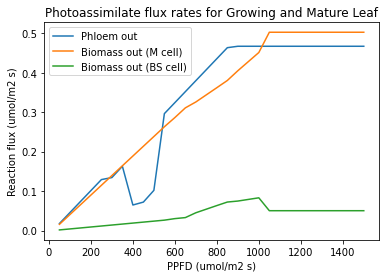

In [14]:
#Let's graph the initial results first

#plot PPFD vs CO2 uptake

phloem_trans_out = ppfd_2cell_trans_phloem.loc[['DM_Phloem_BS']].values.flatten()
biomass_trans_M = ppfd_2cell_trans_bm.loc[['Straw_Biomass_M']].values.flatten()
biomass_trans_BS = ppfd_2cell_trans_bm.loc[['Straw_Biomass_BS']].values.flatten()

phloem_out = ppfd_2cell_wt_phloem.loc[['DM_Phloem_BS']].values.flatten()
biomass_out_M = ppfd_2cell_wt_bm.loc[['Straw_Biomass_M']].values.flatten()
biomass_out_BS = ppfd_2cell_wt_bm.loc[['Straw_Biomass_BS']].values.flatten()
ppfd_e = list(ppfd_2cell_wt_phloem.columns)

plt.plot(ppfd_e, phloem_out, label="Phloem out")
plt.plot(ppfd_e, biomass_out_M, label="Biomass out (M cell)")
plt.plot(ppfd_e, biomass_out_BS, label="Biomass out (BS cell)")
plt.title(label='Photoassimilate flux rates for Growing and Mature Leaf')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Reaction flux (umol/m2 s)')
plt.legend()
plt.show()



#I think I need to graph previous data regarding this?
#Based on this, it shows that photoassimilation becomes unstable in intermediate lights  as opposed to
#Having a more stable output 

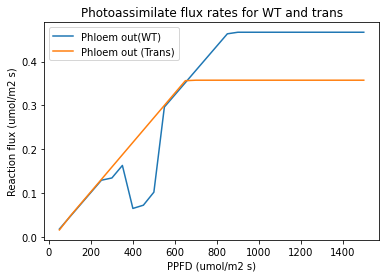

In [15]:
plt.plot(ppfd_e, phloem_out, label="Phloem out(WT)")
plt.plot(ppfd_e, phloem_trans_out, label="Phloem out (Trans)")
plt.title(label='Photoassimilate flux rates for WT and trans')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Reaction flux (umol/m2 s)')
plt.legend()
plt.show()



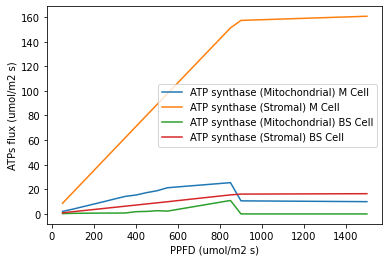

In [16]:
# Plot ATPs_M and ATPSs vs. ppfd
ATPSm_m =  ppfd_2cell_wt_phloem.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  ppfd_2cell_wt_phloem.loc[['ATPSs_M']].values.flatten()
ATPSm_bs = ppfd_2cell_wt_phloem.loc[['ATPSm_BS']].values.flatten()
ATPSs_bs = ppfd_2cell_wt_phloem.loc[['ATPSs_BS']].values.flatten()




plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.legend()
plt.show()


In [ ]:
# Plot ATPs_M and ATPSs vs. ppfd in growing leaf
ATPSm_m =  ppfd_2cell_wt_bm.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  ppfd_2cell_wt_bm.loc[['ATPSs_M']].values.flatten()
ATPSm_bs = ppfd_2cell_wt_bm.loc[['ATPSm_BS']].values.flatten()
ATPSs_bs = ppfd_2cell_wt_bm.loc[['ATPSs_BS']].values.flatten()



plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.title('PPFD vs. ATP Synthase flux in Growing leaves')
plt.legend()
plt.show()


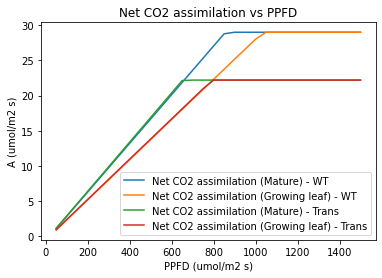

In [17]:
#Show CO2 assimilation comparing growing leaf and mature leaf
co2_wt_mature = ppfd_2cell_wt_phloem.loc[['EX_co2(e)']].values.flatten()
co2_wt_growing = ppfd_2cell_wt_bm.loc[['EX_co2(e)']].values.flatten()
co2_trans_mature = ppfd_2cell_trans_phloem.loc[['EX_co2(e)']].values.flatten()
co2_trans_growing = ppfd_2cell_trans_bm.loc[['EX_co2(e)']].values.flatten()

plt.plot(ppfd_e, co2_wt_mature *-1, label='Net CO2 assimilation (Mature) - WT')
plt.plot(ppfd_e, co2_wt_growing *-1, label='Net CO2 assimilation (Growing leaf) - WT')
plt.plot(ppfd_e, co2_trans_mature *-1, label='Net CO2 assimilation (Mature) - Trans')
plt.plot(ppfd_e, co2_trans_growing *-1, label='Net CO2 assimilation (Growing leaf) - Trans')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD')
plt.legend()
plt.show()


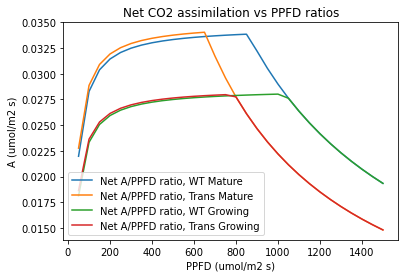

In [19]:
#Show co2 to ppfd ratio comparing growing leaf and mature leaf
#I think it would be better to use flu of PSII instead?




plt.plot(ppfd_e, -1*co2_wt_mature/ppfd_e, label='Net A/PPFD ratio, WT Mature')
plt.plot(ppfd_e, -1*co2_trans_mature/ppfd_e, label='Net A/PPFD ratio, Trans Mature')
plt.plot(ppfd_e, -1*co2_wt_growing/ppfd_e, label='Net A/PPFD ratio, WT Growing')
plt.plot(ppfd_e, -1*co2_trans_growing/ppfd_e, label='Net A/PPFD ratio, Trans Growing')


plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD ratios')
plt.legend()
plt.show()


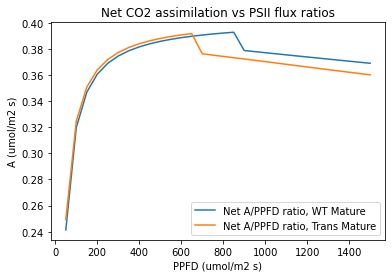

In [21]:
#A vs PSII flux

psii_wt_phl = ppfd_2cell_wt_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_wt_phloem.loc[['PSIINC_BS']].values.flatten()

psii_trans_phl =  ppfd_2cell_trans_phloem.loc[['PSIINC_M']].values.flatten() + \
                ppfd_2cell_trans_phloem.loc[['PSIINC_BS']].values.flatten()




plt.plot(ppfd_e, -1*co2_wt_mature/psii_wt_phl, label='Net A/PPFD ratio, WT Mature')
plt.plot(ppfd_e, -1*co2_trans_mature/psii_trans_phl, label='Net A/PPFD ratio, Trans Mature')

plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PSII flux ratios')
plt.legend()
plt.show()


<ipython-input-22-7b1dd87cc2d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vcvo_bs = rbpc_bs/rbpo_bs


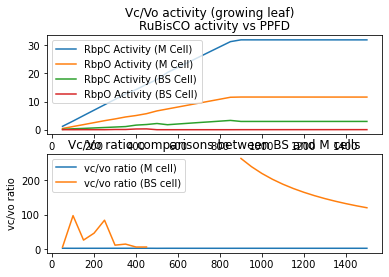

In [22]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_2cell_wt_phloem.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_2cell_wt_phloem.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_2cell_wt_phloem.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_2cell_wt_phloem.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs



fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (growing leaf)')
# fig.set_xlabel('PPFD (umol/m2 s)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_xlabel('RubisCO Flux (umol/m2 s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()


ax2.plot(ppfd_e,  vcvo_m, label='vc/vo ratio (M cell)')
ax2.plot(ppfd_e, vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.set_ylabel('vc/vo ratio')
ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')
ax2.legend()



In [ ]:
vcvo_bs

<ipython-input-23-92dfb007dae7>:7: RuntimeWarning: divide by zero encountered in true_divide
  vcvo_bs = rbpc_bs/rbpo_bs


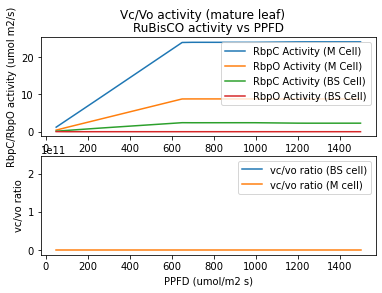

In [23]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_2cell_trans_phloem.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_2cell_trans_phloem.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_2cell_trans_phloem.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_2cell_trans_phloem.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs

vcvo_total = (rbpc_m + rbpc_bs)/(rbpo_m + rbpo_bs)


fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (mature leaf)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_ylabel('RbpC/RbpO activity (umol m2/s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()

ax2.plot(ppfd_e,  vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.plot(ppfd_e, vcvo_m, label='vc/vo ratio (M cell)')
ax2.set_xlabel('PPFD (umol/m2 s)')
ax2.set_ylabel('vc/vo ratio')
ax2.legend()
# ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')


#Top is rubisco fluxes while bottom is vc/vo ratios. Note that the vc/vo ratios at the bottom portion 
#are disrupted due to zero values in a number of 

<AxesSubplot:>

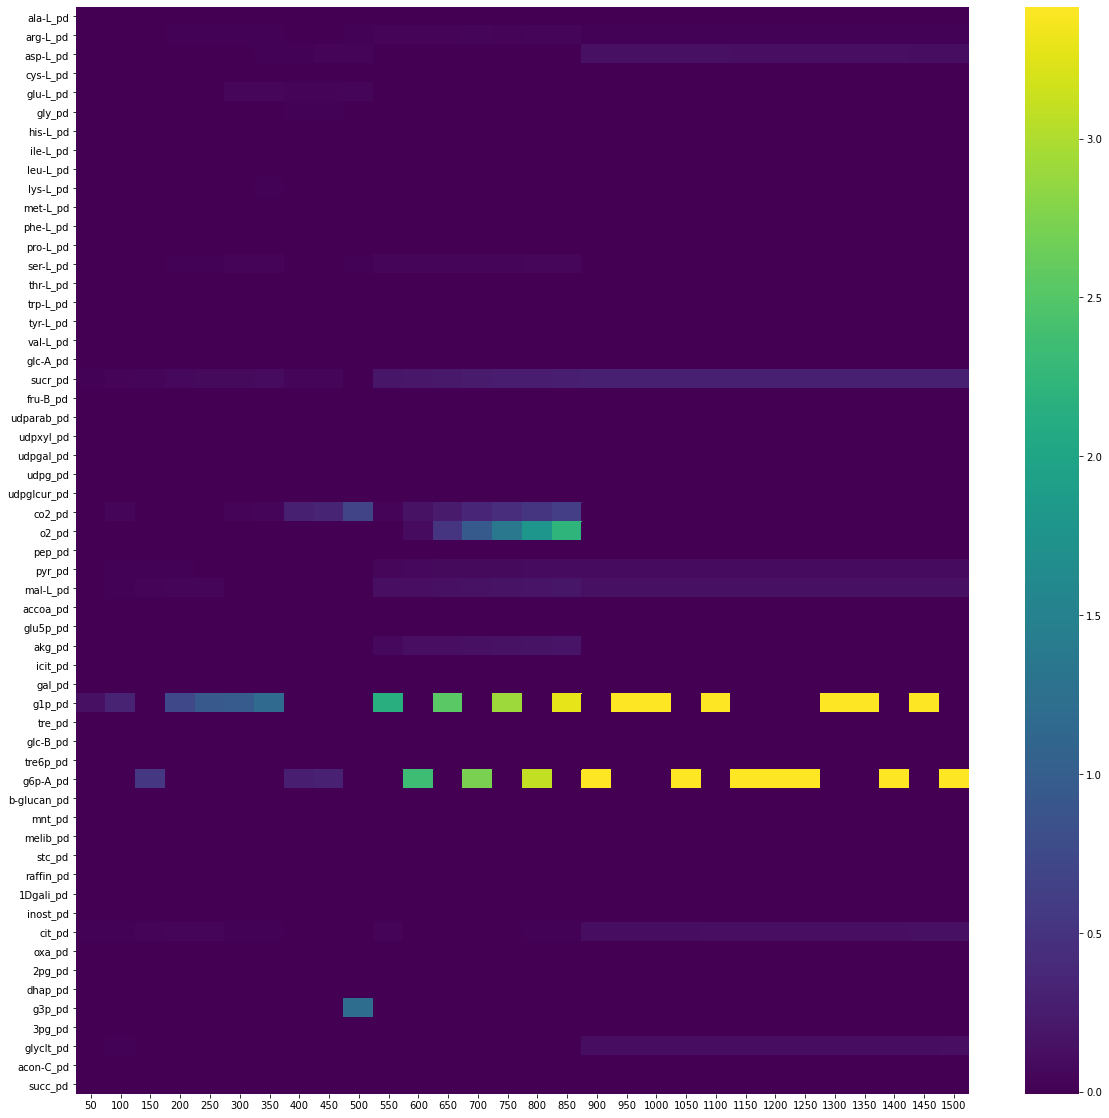

In [24]:
phloem_ppfd = ppfd_2cell_wt_phloem.transpose()

pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis')

<AxesSubplot:>

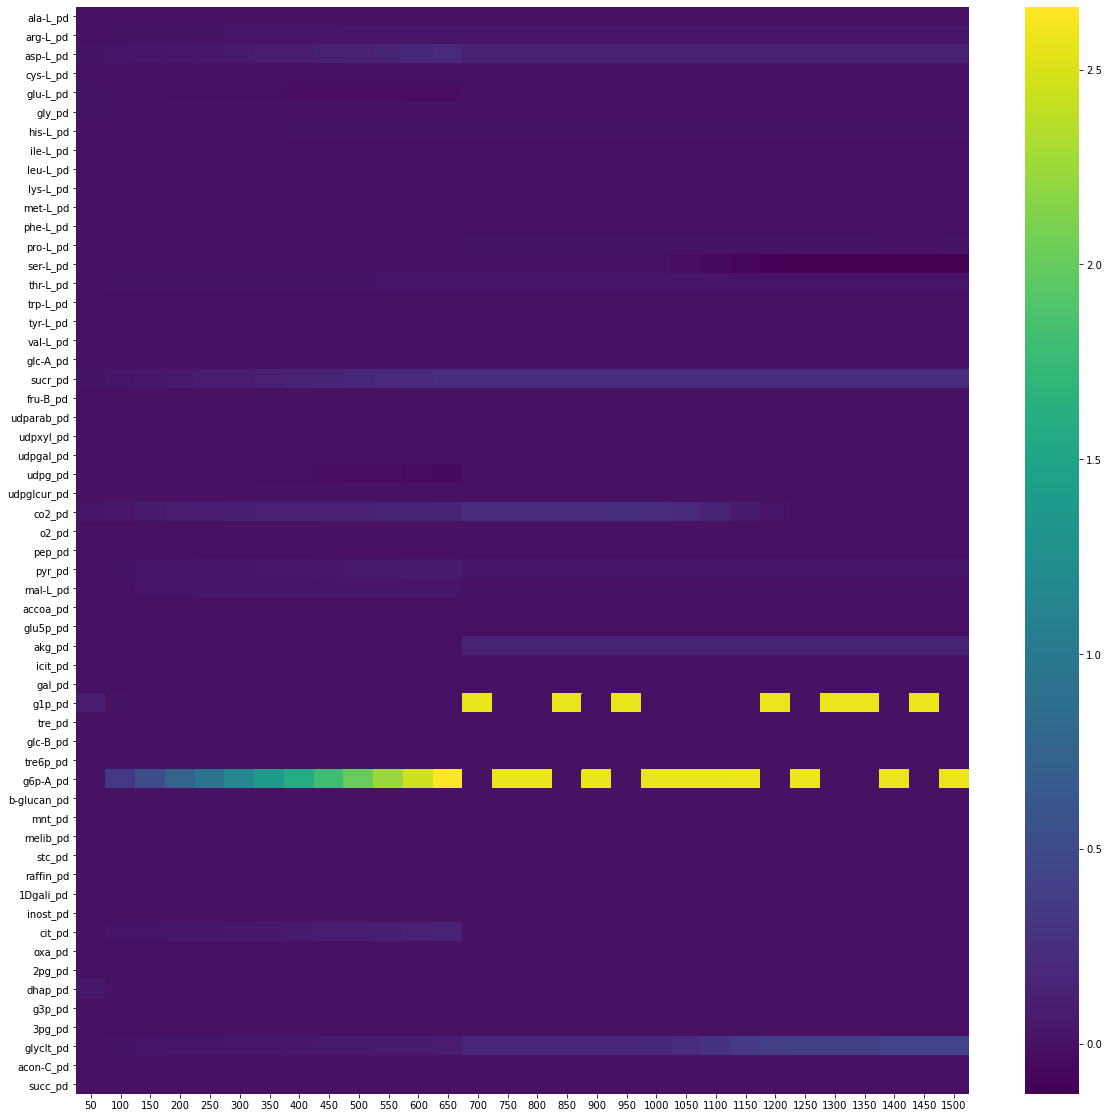

In [25]:
phloem_ppfd = ppfd_2cell_trans_phloem.transpose()

pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis')

<AxesSubplot:>

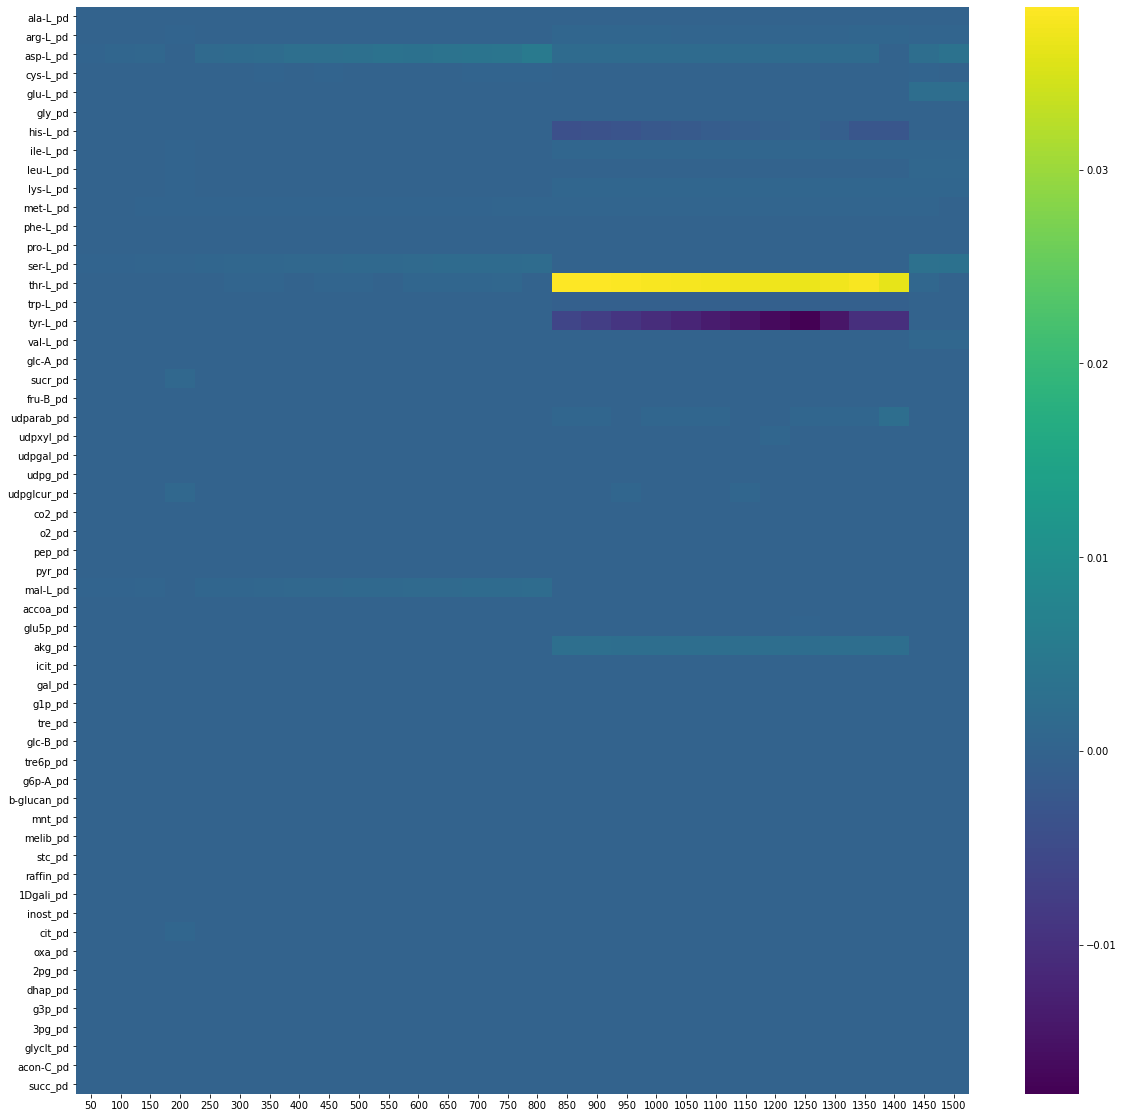

In [26]:
phloem_ppfd = ppfd_2cell_trans_bm.transpose()

pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis')

<AxesSubplot:title={'center':'Plasmodesmatal Transport in Growing Leaf'}>

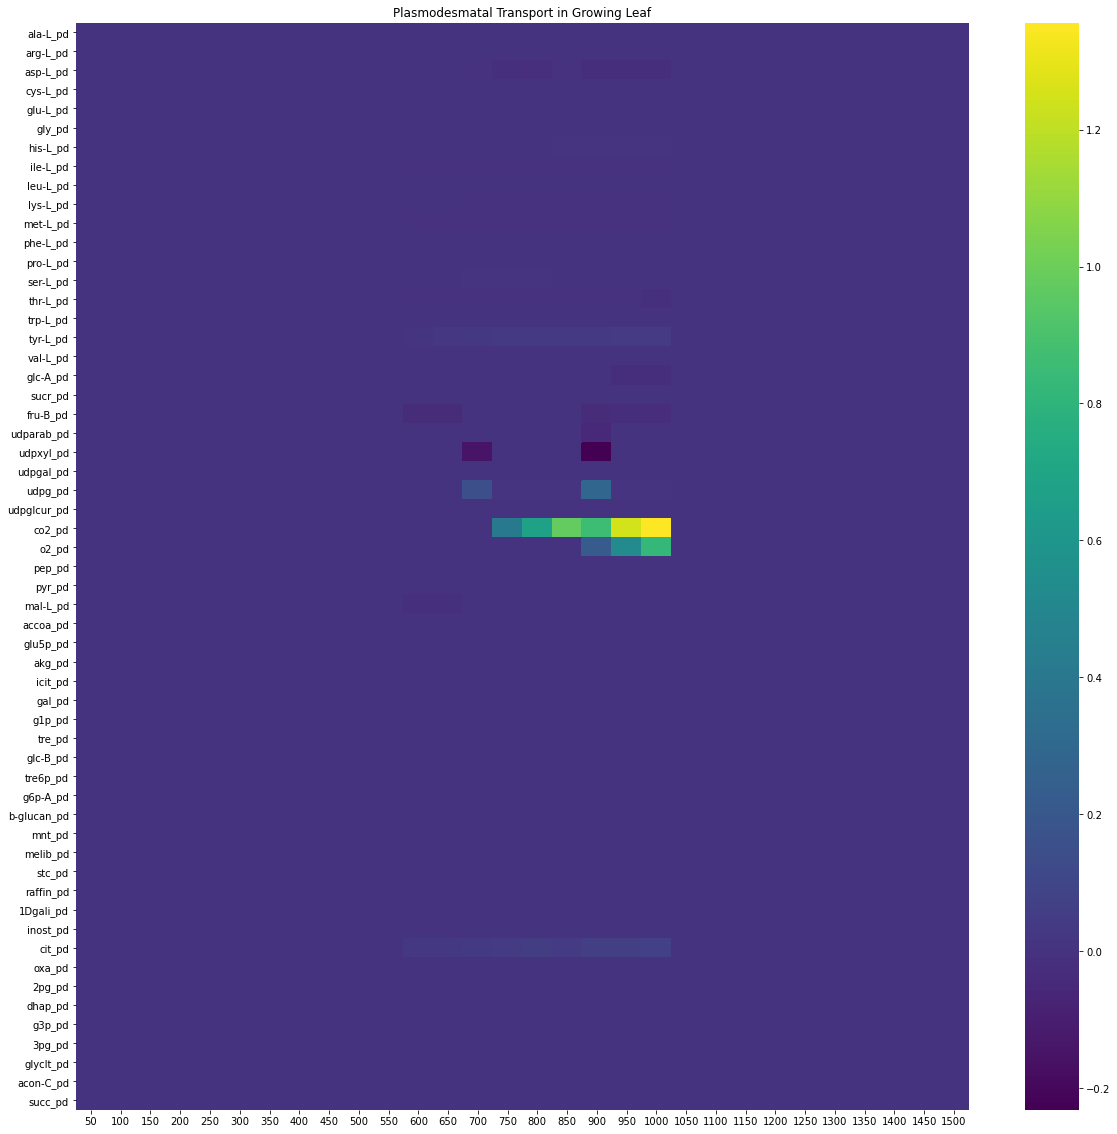

In [27]:
#This heat map shows the Plasmodesmatal reactions in a growing leaf
phloem_ppfd_bm = ppfd_2cell_wt_bm.transpose()
pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd_bm = phloem_ppfd_bm[pd_transport_ids].transpose().replace()



plt.figure(figsize = (20,20))
plt.title('Plasmodesmatal Transport in Growing Leaf')
sns.heatmap(pd_phloem_ppfd_bm, cmap='viridis')

<function matplotlib.pyplot.show(close=None, block=None)>

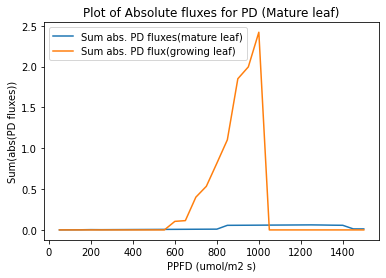

In [28]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux = pd_phloem_ppfd.abs().sum(axis=0)
pd_phloem_abs_flux_bm = pd_phloem_ppfd_bm.abs().sum(axis=0)

plt.plot(pd_phloem_abs_flux.index, pd_phloem_abs_flux, label='Sum abs. PD fluxes(mature leaf)')
plt.plot(pd_phloem_abs_flux_bm.index, pd_phloem_abs_flux_bm.values, label = 'Sum abs. PD flux(growing leaf)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Sum(abs(PD fluxes))')
plt.title('Plot of Absolute fluxes for PD (Mature leaf)')
plt.legend()
plt.show


In [35]:
def subset_fluxes(flux_df, ids):
    df_index = flux_df.index
    if isinstance(ids, tuple):
        subset = flux_df.loc[df_index.str.contains('|'.join(ids))]
    elif isinstance(ids, str):
        subset = flux_df.loc[df_index.str.contains(ids)]
    subset = subset.loc[~(subset==0).all(axis=1)]
    return subset



PEPC_flux = subset_fluxes(ppfd_2cell_wt_phloem, ('PPCc', 'PPCs'))
PPDK_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'PPDKs')
RBPC_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'RBPC')
RBPO_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'RBPO')
HCO3E_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'HCO3E')
MDH_flux = subset_fluxes(ppfd_2cell_wt_phloem, 'MDH')
MDHy_flux = subset_fluxes(MDH_flux, 'MDHy')


MDH_flux

,50,100,150,200,250,300,350,400,450,500,...,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500
MDHs_M,-0.001523,-0.003922,-0.006321,-0.008720,-0.011119,-0.013518,-0.015916,-0.018315,-0.020714,-0.023113,...,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605,-0.018605
MDHc_M,-1.765099,-2.760085,-3.795005,-4.796876,-5.914591,-6.870273,-7.834259,-8.747215,-9.953964,-9.945991,...,0.000000,0.000000,-0.118233,0.000000,0.000000,0.000000,0.000000,-0.116848,0.000000,-0.116294
MDHx_M,0.000000,0.000000,0.000000,0.000000,0.111264,0.000000,0.000000,0.000000,0.207526,0.000000,...,0.280482,0.280482,0.398715,0.280482,0.280482,0.280482,0.280482,0.397330,0.280482,0.396776
MDHm_M,1.780768,2.789477,3.842374,4.862672,5.893440,7.015788,8.010501,8.971460,10.000054,10.228977,...,0.018605,0.018605,0.018605,0.018605,0.018605,0.018605,0.018605,0.018605,0.018605,0.018605
MDHARyc_M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IMDHTs_M,0.000304,0.000783,0.000000,0.001742,0.002221,0.002700,0.003179,0.003658,0.004138,0.004617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IMDHs_M,0.000304,0.000783,0.000000,0.001742,0.002221,0.002700,0.003179,0.003658,0.004138,0.004617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MDHs_BS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608,-0.021608
MDHc_BS,-0.212857,-0.365589,-0.478387,-0.624234,-0.765502,-0.846274,-1.030006,-1.264768,-1.413263,-2.361429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MDHx_BS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:



PEP_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, ('PPCc', 'PPCs'))
PPD_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'PPDK')
RBPC_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'RBPC')
RBPO_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'RBPO')
HCO3_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'HCO3E')
MDH_trans_flux = subset_fluxes(ppfd_2cell_trans_phloem, 'MDH')
MDHy_trans_flux = subset_fluxes(MDH_trans_flux, 'MDHy')


MDHy_trans_flux

,50,100,150,200,250,300,350,400,450,500,...,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500
MDHys_M,0.000000,-0.000683,-0.001284,-0.001769,-0.002253,-0.002738,-0.003222,-0.003707,-0.004191,-0.004676,...,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149,-0.006149
MDHys_BS,0.000000,0.000683,0.001284,0.001769,0.002253,0.002738,0.003222,0.003707,0.004191,0.004676,...,0.006149,0.006149,0.006149,0.006149,0.006149,0.006149,0.006149,0.006149,0.006149,0.006149
trans_MDHym_M,0.328364,0.342805,0.357247,0.371688,0.386130,0.400571,0.415013,0.429454,0.443896,0.458337,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000


In [ ]:
ppfd_2cell_trans_phloem

Initial thoughts:
- Based on the Light scan experiments above we can see quite a greater variation in terms of Phloem output between flux ranges 200 to 500, and we can also see a minor increase in Rubisco activity in the BS cells. However, I think this still needs to be tested via flux sampling to determine the actual range.
- A similar dip exists even in the Wild type mature leaf but generally stabilizes faster compared to the transgenic rice. 
- I believe this is linked to ATP balancing and the transition from Mitochondrial ATP production to stromal ATP production.

- FUrthermore, I've observed that Rubisco activiity is also limited by Formate Dehydrogenase activity. When it is closed, Rubisco activity is only limited to around ~40 umol m2/s flux values (30 vc + 10 vo) while increasing the upper bound of FDHNc to around 25 allows it to have a ceiling of ~80 umol m2/s, which is around the experimental Rubisco activity measured by Ermakova et al (2021)
    - However, turning this reaction on causes the model to produce ATP with a flux rate that's almost x2 that of previous modelling attempts as checked from Shameer et al (2018, 2021). Furthermore, in Shameer et al (2021) the ranges for Rubisco carboxylation plays around 28-31, which is the maximum rate observed in this experiment. I think this would be a more viable route if ever.
    - Furthermore, based on Shameer et al's hybrid model and flux distributions the ATPase flux values are quite concordant with each other.
    - Lastly, the results pertaining to ATP synthesis is quite concordant with the results obtained by Shameer et al in their 2018 publication wherein mito-stromal ATP synthase shift was also observed.
    
    - Weirdly enough I'm observing that the addition of the trans constraints caused the flow of CO2 directly from the M cell to the BS cell at moderate light conditions, as opposed to the WT. Furthermore, more background flux is observed in all cases in the transgenic 2 cell. 
        - I need to check whether the absolute fluxes actually varied in these cases.
    
    - In both WT and Transgenic models Pyruvate is the predominant flux at low to medium light levels, while in the Transgenic model there is actual Gas flux from M to BS cells (both CO2 and O2)
    - In the transgenic model some flux of Glycolate from the M cell is detected in high light conditions (>750 ppfd) while some backflow of g3p from the BS cell to the M cell is observed.
    - PPFD to CO2 assimilation is much more steeper than what I've obtained in the past. I wonder why? I'm not too sure about it either
        - I think it is because I was only inputting NO3 into the mix rather than both NH3/NO3, as well as having free H+ import, which I closed. 
            - Upon testing this, I've observed that limiting H+ import now prevents that sharp increase in CO2 assimilation, with Max A approximately around 800 ppfd. Furthermore, an infeasible solution is now obtained for light intensities below 50 umol m2/s owing to the lack of source for proton demand. 
            - Adjusting this, an A roughly equivalent to the measured dark respiration values measured by Ermakova et al (2021)  is now obtained around 50 ppfd (Which, conversely, is the threshold designated by Topfer et al (2020) to delineate light compensation.
                - Maybe I can design an experiment to find the minimum value where the solver can find a feasible solution, then compare that to the trans one?
            -Adjusting the H+ demand (by allowing H+ import and varying import rates) actually removes the inverse relationship between Mitochondrial and Stromal ATP synthase flux. What gives?
                - I think modelling artifact yun since it allows system to simply import yung surplus H+ nila even though it could be supplied by photosynthesis (H2O  -> 2H2 + O2 based nga dun sa light reaction stoichiometry)
    

#Notes: Nov 26, 2022
I've revised the reaction for PEPC which I've changed from CO2 +H2O + PEP <-> Pi + H+ + OAA to HCO3 + PEP <-> Pi + OAA

In [ ]:
#Other artifacts as of the moment include the following:
#model doesn't produce any Oxygen. Maybe I should add a specific demand reaction for it?
#Based on FVA, the model now produces some oxygen via the demand reaction. 

In [ ]:
#Model also facilitates transfer of metabolites unlike before.

In [ ]:
#Questions:
#Should I restrict Nutrient flow to the Bundle Sheath Cell only or should I allow flux to both the M and BS cell?
#Apparently kasi dito only the Bundle sheath cells produce any biomass
#This is to ensure that only CO2 and Light flux are the only limiting constraints to the system.